<a href="https://colab.research.google.com/github/zahraDehghanian97/TFIDF_Spark/blob/master/BD1_Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Mining Course Spark Exercise
## Sharif University of Technology

In this notebook we are going to analyze farsi wikipedia. 
Outline of the exercise:
* Dataset preparation
* Preprocessing (25 Points) 
* Exploration (20 Points) 
* TF-IDF + Search (55 Points)

You should replace the `TODO` parts with your implementation. Remeber that each `TODO` may take multiple lines and you shouldn't limit your self to one-line codes.

## Prerequisites
You should be faimilar with [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). In this notebook you should use the following formula for tf-idf:
$$f_{t,d}/len(d) \times log(1 + \frac{N}{n_t})$$

## Warning: RDD api only
You **can not** use Dataframe, Dataset, mllib, ml, ... apis of spark in this exercise. You should only use the [RDD api](http://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD).

# Section 0: Please enter your name below
# Name: Zahra Dehghanian
# Student Number: 401300417

# Section 1: Dataset preparation 

This section of notebook contains only shell commands. You don't need to completely understand each command or change anything.

Please run all the paragraphs sequentially.

In [1]:
! sudo apt-get -y install wget git

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.17.1-1ubuntu0.13).
wget is already the newest version (1.19.4-1ubuntu2.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


## Download the dump

In [2]:
! wget --no-check-certificate -P . https://dumps.wikimedia.org/fawiki/latest/fawiki-latest-pages-articles-multistream.xml.bz2

--2022-11-30 10:08:39--  https://dumps.wikimedia.org/fawiki/latest/fawiki-latest-pages-articles-multistream.xml.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.142, 2620:0:861:2:208:80:154:142
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1119345079 (1.0G) [application/octet-stream]
Saving to: ‘./fawiki-latest-pages-articles-multistream.xml.bz2.2’

fawiki-latest-pages 100%[===================>]   1.04G  4.81MB/s    in 3m 55s  

2022-11-30 10:12:34 (4.55 MB/s) - ‘./fawiki-latest-pages-articles-multistream.xml.bz2.2’ saved [1119345079/1119345079]



## Extract the dump (this may take a few minutes)

In [3]:
! bzip2 -d fawiki-latest-pages-articles-multistream.xml.bz2

## Clone git project for converting wikipedia xml dump to json

In [4]:
! pip install wikiextractor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Run the script to convert xml to json (this might take around 30 minutes)

In [5]:
! python -m wikiextractor.WikiExtractor --json fawiki-latest-pages-articles-multistream.xml

INFO: Preprocessing 'fawiki-latest-pages-articles-multistream.xml' to collect template definitions: this may take some time.
INFO: Preprocessed 100000 pages
INFO: Preprocessed 200000 pages
INFO: Preprocessed 300000 pages
INFO: Preprocessed 400000 pages
INFO: Preprocessed 500000 pages
INFO: Preprocessed 600000 pages
INFO: Preprocessed 700000 pages
INFO: Preprocessed 800000 pages
INFO: Preprocessed 900000 pages
INFO: Preprocessed 1000000 pages
INFO: Preprocessed 1100000 pages
INFO: Preprocessed 1200000 pages
INFO: Preprocessed 1300000 pages
INFO: Preprocessed 1400000 pages
INFO: Preprocessed 1500000 pages
INFO: Preprocessed 1600000 pages
INFO: Preprocessed 1700000 pages
INFO: Preprocessed 1800000 pages
INFO: Preprocessed 1900000 pages
INFO: Preprocessed 2000000 pages
INFO: Preprocessed 2100000 pages
INFO: Preprocessed 2200000 pages
INFO: Preprocessed 2300000 pages
INFO: Preprocessed 2400000 pages
INFO: Preprocessed 2500000 pages
INFO: Preprocessed 2600000 pages
INFO: Preprocessed 2700000

## Ensure output files exist

In [6]:
! ls text/*/*

text/AA/wiki_00  text/AI/wiki_64  text/AR/wiki_28  text/AZ/wiki_92
text/AA/wiki_01  text/AI/wiki_65  text/AR/wiki_29  text/AZ/wiki_93
text/AA/wiki_02  text/AI/wiki_66  text/AR/wiki_30  text/AZ/wiki_94
text/AA/wiki_03  text/AI/wiki_67  text/AR/wiki_31  text/AZ/wiki_95
text/AA/wiki_04  text/AI/wiki_68  text/AR/wiki_32  text/AZ/wiki_96
text/AA/wiki_05  text/AI/wiki_69  text/AR/wiki_33  text/AZ/wiki_97
text/AA/wiki_06  text/AI/wiki_70  text/AR/wiki_34  text/AZ/wiki_98
text/AA/wiki_07  text/AI/wiki_71  text/AR/wiki_35  text/AZ/wiki_99
text/AA/wiki_08  text/AI/wiki_72  text/AR/wiki_36  text/BA/wiki_00
text/AA/wiki_09  text/AI/wiki_73  text/AR/wiki_37  text/BA/wiki_01
text/AA/wiki_10  text/AI/wiki_74  text/AR/wiki_38  text/BA/wiki_02
text/AA/wiki_11  text/AI/wiki_75  text/AR/wiki_39  text/BA/wiki_03
text/AA/wiki_12  text/AI/wiki_76  text/AR/wiki_40  text/BA/wiki_04
text/AA/wiki_13  text/AI/wiki_77  text/AR/wiki_41  text/BA/wiki_05
text/AA/wiki_14  text/AI/wiki_78  text/AR/wiki_42  text/BA/wik

## Install Pypark & Initialization
Uncomment this section if you use google colab or local pc

In [7]:
! pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("MDA_2021") \
    .master("local[*]") \
    .getOrCreate()

sc=spark.sparkContext

## Reading the data

In [9]:
articles_rdd1 = sc.textFile("text/*/*") # Now you have a RDD with wikipedia posts
articles_rdd = articles_rdd1.sample(False,0.001)
articles_rdd.take(30)

['{"id": "6475", "revid": "35903327", "url": "https://fa.wikipedia.org/wiki?curid=6475", "title": "\\u0641\\u062a\\u062d\\u0639\\u0644\\u06cc\\u200c\\u0634\\u0627\\u0647", "text": "\\u0641\\u062a\\u062d\\u0639\\u0644\\u06cc\\u200c\\u0634\\u0627\\u0647 \\u0642\\u0627\\u062c\\u0627\\u0631 (\\u06f1\\u06f8 \\u0634\\u0648\\u0627\\u0644 \\u06f1\\u06f1\\u06f8\\u06f5 \\u2013 \\u06f1\\u06f9 \\u062c\\u0645\\u0627\\u062f\\u06cc\\u200c\\u0627\\u0644\\u062b\\u0627\\u0646\\u06cc \\u06f1\\u06f2\\u06f5\\u06f0) \\u062f\\u0648\\u0645\\u06cc\\u0646 \\u0634\\u0627\\u0647 \\u0627\\u0632 \\u062f\\u0648\\u062f\\u0645\\u0627\\u0646 \\u0642\\u0627\\u062c\\u0627\\u0631 \\u0628\\u0648\\u062f \\u06a9\\u0647 \\u0627\\u0632 \\u0633\\u0627\\u0644 \\u06f1\\u06f7\\u06f9\\u06f7 \\u062a\\u0627 \\u06f1\\u06f8\\u06f3\\u06f4 \\u0645\\u06cc\\u0644\\u0627\\u062f\\u06cc \\u0634\\u0627\\u0647 \\u0627\\u06cc\\u0631\\u0627\\u0646 \\u0628\\u0648\\u062f. \\u0627\\u0648\\u060c \\u06cc\\u06a9\\u06cc \\u0627\\u0632 \\u0627\\u0639\\u0

# Section 2: Preprocessing (25 Points)

In this section we will remove useless part (for example /n and /u200c) also find and remove stop words and remove the words with a low count in the corpus

In [10]:
import json 

articles_rdd = articles_rdd.map(lambda x: [json.loads(x)['url'], json.loads(x)['title'], json.loads(x)['text']])
cleaning = ['&gt','&lt','=','+','۱','_','–','-','\"','\'','۲','۳','۴','۵','۶','۷','۸','۹','۰',':','.','،','.',',','«','»',')','(','!','{','}','[',']','?','>','<','@','|','*','#',';','/','1','2','3','4','5','6','7','8','9','0','۰']
cleansed_articles_rdd = articles_rdd.map(lambda x:  [x[0], ' '.join(''.join(" " if c in cleaning else c for c in x[1].replace('\u200c', ' ').replace('\n', ' ').replace('__NOEDITSECTION__',' ').replace('/styles.css"/&gt;',' ').replace('&lt;templatestyles src=',' ').replace('UTC             –                 ',' ')).split()), ' '.join(''.join(" " if c in cleaning else c for c in x[2].replace('\u200c', ' ').replace('\n', ' ').replace('__NOEDITSECTION__',' ').replace('/styles.css"/&gt;',' ').replace('&lt;templatestyles src=',' ').replace('UTC             –                 ',' ')).split())       ] )
words_rdd = cleansed_articles_rdd.flatMap(lambda line: (line[1] + line[2]).split(" "))
words_count_rdd = words_rdd.map(lambda word: (word, 1)).reduceByKey(lambda a,b:a+b)
stopwords = words_count_rdd.takeOrdered(100, key = lambda x: -x[1]) # take 100 most common word
stopwords = [x[1] for x in stopwords]
stopwords.append('با')
stopwords.append('و')
articles_without_stopwords_rdd = cleansed_articles_rdd.map(lambda x: [x[0], ' '.join(' '.join("" if c in stopwords else c for c in x[1].split()).split()), ' '.join(' '.join("" if c in stopwords else c for c in x[2].split()).split())])
MIN_COUNT = 20
uncommon_words = words_count_rdd.filter(lambda x: x[1] < MIN_COUNT).collect()
uncommon_words = [x[1] for x in uncommon_words]
articles_cleaned_rdd = articles_without_stopwords_rdd.map(lambda x: [x[0], ' '.join(' '.join("" if c in uncommon_words else c for c in x[1].split()).split()), ' '.join(' '.join("" if c in uncommon_words else c for c in x[2].split()).split())])
articles_cleaned_rdd.take(1)


[['https://fa.wikipedia.org/wiki?curid=6475',
  'فتحعلی شاه',
  'فتحعلی شاه قاجار شوال جمادی الثانی دومین شاه از دودمان قاجار بود که از سال تا میلادی شاه ایران بود او یکی از اعضای سلسلهٔ قاجار برادرزادهٔ آقامحمدخان بود به مدت سال ماه بر ایران حکومت کرد مهم ترین اتفاقاتی که در زمان حکومت فتحعلی شاه روی داد وقوع دو جنگ میان ایران روسیه بود که ارتش ایران در آن ها شکست خورد نتیجهٔ این جنگ ها امضای عهدنامه های ترکمانچای گلستان بود که به موجب آن بخش های بزرگی از قلمروهای شمال غربی ایران که شامل کشورهای معاصر ارمنستان گرجستان داغستان جمهوری آذربایجان نخجوان می شود از ایران جدا به روسیه ملحق شدند کریم خان زند پس از سرکوب شورش محمدحسن خان قاجار در شمال ایران دو پسر وی به نام های آقامحمدخان حسینقلی خان جهانسوز را خود به شیراز برد کریم خان زند آقامحمدخان را خود در شیراز نگه داشت حکومت دامغان را به حسینقلی خان جهانسوز سپرد فتحعلی شاه فرزند حسینقلی خان جهانسوز برادرزادهٔ آقامحمدخان بود فتحعلی شاه پس از کشته شدن عمویش آقامحمدخان به پادشاهی رسید؛ زیرا آقامحمدخان خواجه بود فرزندی نداشت تولد کودکی فتحع

# Section 3: Exploration (20 Points)
Please answer the following questions regarding the dataset:
* How many unique 3-Letter words remain after the cleaning procedure?
* What are the top 20 most common English trigrams in the corpus?
* Plot a distribution from document lengths using appropriate bin sizes with 100 bins
* What are the titles and urls of the 5 longest articles? 
* How many and what percentage of articles contain these words? [History, Politics, Medicine, Law, Economics, Engineering]


In [11]:
# How many unique 3-Letter words remain after the cleaning procedure?
def three_letter (a):
  if len(a)==3:
    return True
  else :
    return False

words = articles_cleaned_rdd.flatMap(lambda line: (line[1] + line[2]).split(" "))
unique_3_letter_words = words.filter(lambda x: three_letter(x))
c = unique_3_letter_words.distinct().count()
print(c)


1574


In [13]:
# # What are the top 20 most common English trigrams in the corpus?

def isEnglish(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

def trigram(word):
  s = list(word)
  result = []
  if len(s)>2 :
    for i in range(len(s)-2):
      result.append(s[i] + s[i+1] + s[i+2])
  return result

words = articles_cleaned_rdd.flatMap(lambda line: (line[1] + line[2]).split(" "))
english_words = words.filter(lambda x: isEnglish(x))
trigrams = english_words.flatMap(lambda x : trigram(x))
wordcount = trigrams.map(lambda tword: (tword, 1)).reduceByKey(lambda a,b:a+b)
common_english_trigrams = wordcount.takeOrdered(20, key = lambda x: -x[1])
print(common_english_trigrams)

[('for', 54), ('ula', 52), ('orm', 51), ('mul', 50), ('rmu', 49), ('DNA', 40), ('ion', 29), ('tio', 24), ('ing', 23), ('ter', 20), ('her', 16), ('ati', 15), ('edi', 15), ('dia', 14), ('iki', 14), ('ton', 14), ('all', 13), ('CTU', 13), ('est', 13), ('and', 13)]


[[   0 1850]
 [   2    1]
 [   4    1]
 [   6    2]
 [   7    6]
 [   8    5]
 [   9   18]
 [  10   22]
 [  11   24]
 [  12   14]
 [  13   15]
 [  14   15]
 [  15   15]
 [  16   11]
 [  17   24]
 [  18   25]
 [  19   23]
 [  20   27]
 [  21   30]
 [  22   22]
 [  23   11]
 [  24   13]
 [  25   15]
 [  26   15]
 [  27   16]
 [  28   15]
 [  29   14]
 [  30   12]
 [  31   14]
 [  32   14]
 [  33   21]
 [  34   24]
 [  35   19]
 [  36   15]
 [  37   27]
 [  38   12]
 [  39   12]
 [  40   17]
 [  41   12]
 [  42   19]
 [  43   11]
 [  44    5]
 [  45    5]
 [  46   10]
 [  47    1]
 [  48    7]
 [  49    7]
 [  50    7]
 [  51    5]
 [  52    2]
 [  53    1]
 [  54    1]
 [  55    3]
 [  56    3]
 [  57    2]
 [  58    4]
 [  59    3]
 [  60    2]
 [  61    5]
 [  62    4]
 [  63    1]
 [  64    1]
 [  65    2]
 [  66    2]
 [  67    2]
 [  68    3]
 [  69    1]
 [  71    1]
 [  72    2]
 [  73    1]
 [  74    1]
 [  75    3]
 [  76    1]
 [  77    2]
 [  80    1]
 [  81    2]
 [  82    2]

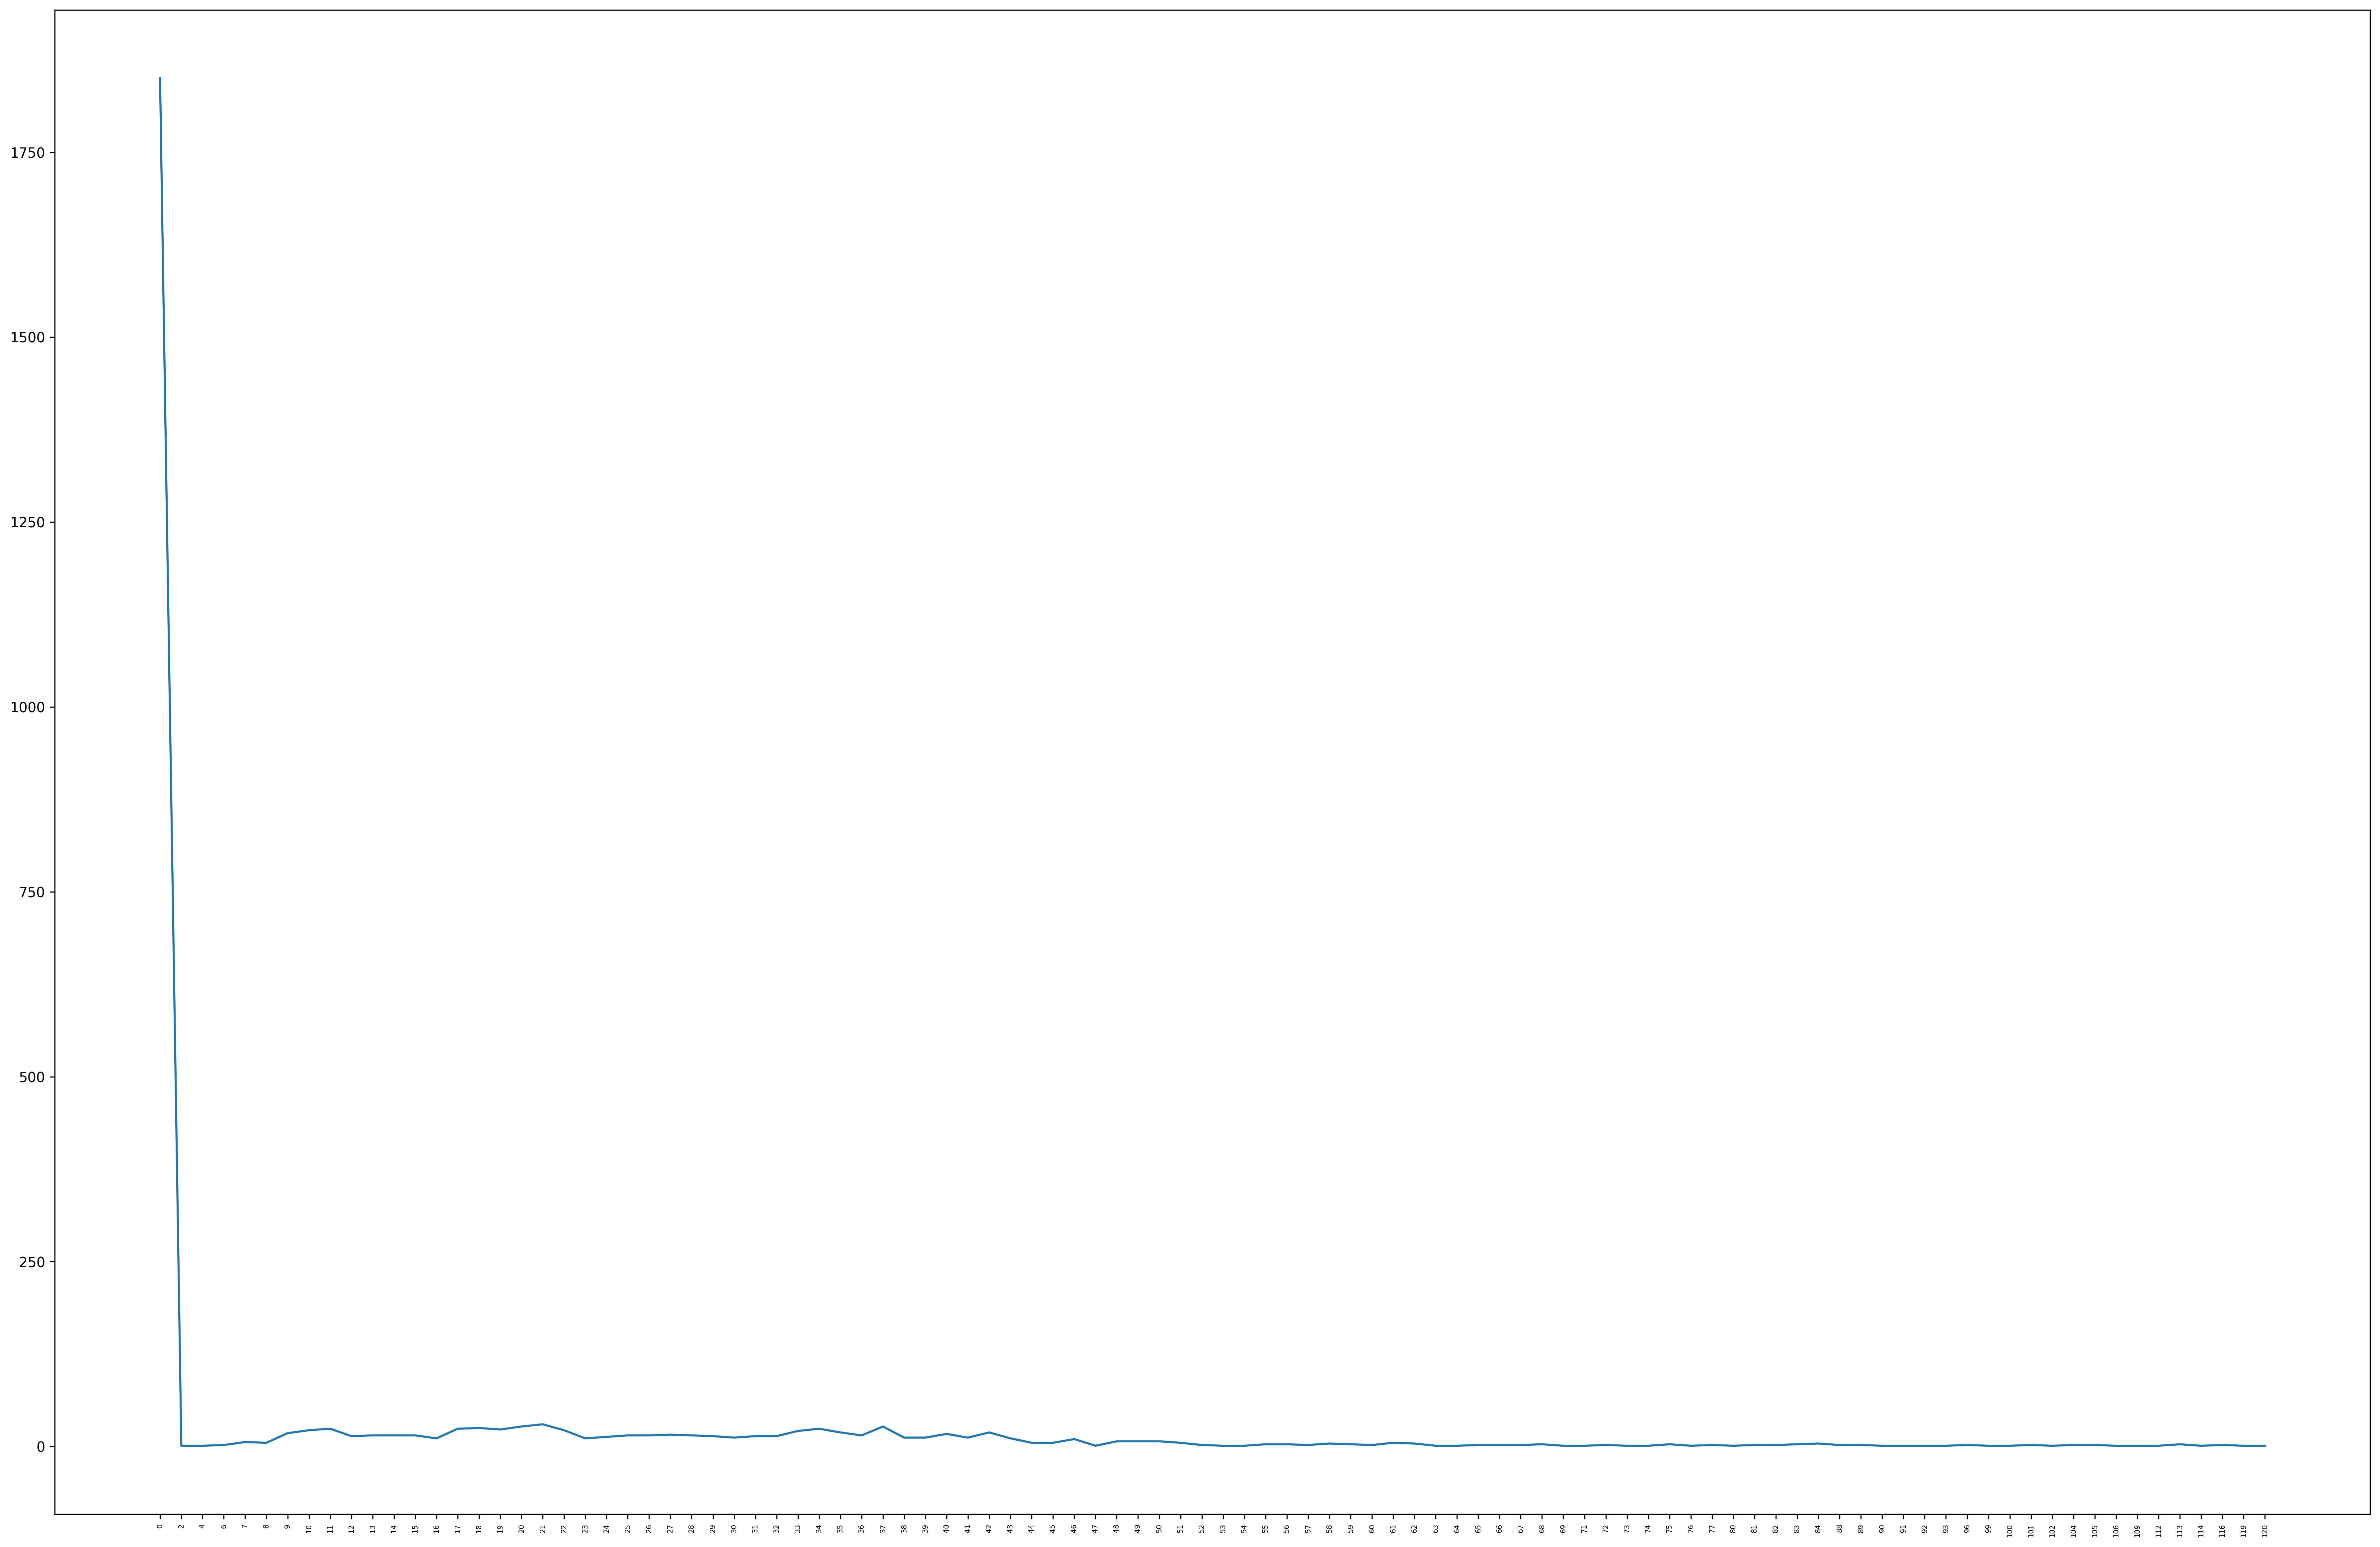

In [14]:
# Plot a distribution from document lengths using appropriate bin sizes with 100 bins

import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.pyplot import figure


doc_length = articles_cleaned_rdd.map(lambda x: (x[0], len(x[2].split())))
doc_length.take(10)
doc_length = articles_cleaned_rdd.map(lambda x: (len(x[2].split()), 1)).reduceByKey(lambda a,b:a+b)
doc_length_all = doc_length.collect()
doc_length_all = np.array(doc_length_all)
print(doc_length_all)
doc_length_all = doc_length_all[doc_length_all[:, 0].argsort()]

figure(figsize=(30, 20), dpi=300)
positions = [i for i in range(100)]
labels = doc_length_all[:100, 0]
plt.xticks(positions, labels, fontsize=5, rotation = 90)
plt.plot(doc_length_all[:100,1])
plt.show()

In [15]:
# What are the titles and urls of the 5 longest articles?

doc_length = articles_cleaned_rdd.map(lambda x: ([x[0],x[1]], len(x[2].split())))
longest_article = doc_length.takeOrdered(5, key = lambda x: -x[1])
print(longest_article)



[(['https://fa.wikipedia.org/wiki?curid=6475', 'فتحعلی شاه'], 9160), (['https://fa.wikipedia.org/wiki?curid=2321732', 'اینترنت اشیاء'], 4897), (['https://fa.wikipedia.org/wiki?curid=359368', 'مرگ مایکل جکسون'], 4702), (['https://fa.wikipedia.org/wiki?curid=281247', 'اسپهبد خورشید'], 4519), (['https://fa.wikipedia.org/wiki?curid=5943893', 'گروه سای'], 2742)]


In [ ]:
# How many and what percentage of articles contain these words? [History, Politics, Medicine, Law, Economics, Engineering]
selected_words =['تاریخ','سیاست','دارو','قانون','اقتصاد','مهندسی'] # [History, Politics, Medicine, Law, Economics, Engineering]
for i in selected_words:
  count_selected_words = articles_cleaned_rdd.map(lambda x: (x[0],1) if (i in x[2]) else (x[0],0)).filter(lambda x : x[1]>0).count()
  print("count of article contains "+i+" : "+str(count_selected_words))

count of article contains تاریخ : 107


# Section 4: TF-IDF + Searching (55 Points)



IDF =Log[(# Number of documents) / (Number of documents containing the word)] 

TF = (Number of repetitions of word in a document) / (# of words in a document)

In [18]:
import math
from pyspark.sql.functions import *

D = articles_cleaned_rdd.count()
word_df_rdd = articles_cleaned_rdd.flatMap(lambda x: [((x[0],i, len(x[2].split())),1) for i in x[2].split()]).reduceByKey(lambda x,y:x+y)
articles_tf_idf_vectors2 = word_df_rdd.map(lambda x: (x[0][1],(x[0][0], x[0][2],x[1]/x[0][2])))
articles_tf_idf_vectors = word_df_rdd.map(lambda x: (x[0][1],1)).reduceByKey(lambda x,y:x+y)
idf=articles_tf_idf_vectors.map(lambda x: (x[0],math.log10((D+1)/(x[1]+1))))
rdd=articles_tf_idf_vectors2.join(idf).map(lambda x: ((x[0],x[1][0][0], x[1][0][1]), float(x[1][1])*float(x[1][0][2])))
rdd.take(10)

[(('پایدار', 'https://fa.wikipedia.org/wiki?curid=4276512', 2256),
  0.0013165056633965234),
 (('پایدار', 'https://fa.wikipedia.org/wiki?curid=5319901', 1007),
  0.0029493910393471267),
 (('است؟', 'https://fa.wikipedia.org/wiki?curid=2321732', 4897),
  0.0006424602890909206),
 (('سیارکی', 'https://fa.wikipedia.org/wiki?curid=34413', 333),
  0.009447831938973687),
 (('بانوی', 'https://fa.wikipedia.org/wiki?curid=5634744', 618),
  0.004805884751816435),
 (('بانوی', 'https://fa.wikipedia.org/wiki?curid=3762185', 178),
  0.016685599868666048),
 (('پیشکسوت', 'https://fa.wikipedia.org/wiki?curid=17522', 739),
  0.00425727745017353),
 (('مرغوب', 'https://fa.wikipedia.org/wiki?curid=544610', 947),
  0.0033222048951195753),
 (('پلاک', 'https://fa.wikipedia.org/wiki?curid=11875', 656),
  0.009591853767311703),
 (('سیز', 'https://fa.wikipedia.org/wiki?curid=967417', 32),
  0.09831650111494494)]

## Searching
In this section you should find articles that are about the topics mentioned in the last part of the third section.
Report the percentage of articles that are about the mentioned topics, for example, report what percentage of the articles were about history?
For each topic, report two of the most relevant articles along with the title and the url.
Check this part in **theory** before practical implementation (Hint: Use the concept of tf-idf).
All innovative solutions are also welcome. Compare the obtained results with the third part.

In [23]:
for i in selected_words:
  result1 = rdd.filter(lambda x : x[0][0] == i )
  most_similar = result1.takeOrdered(2, key = lambda x: -x[1])
  count = result1.count()
  print("the most 2 relevant result for "+i+" : ")
  print(most_similar)
  print("number of relevant article : ")
  print(count)
  print("the percentage of article about this word is : ")
  print(count*100 / D)
  print("---------------------------->")



the most 2 relevant result for تاریخ : 
[(('تاریخ', 'https://fa.wikipedia.org/wiki?curid=659425', 37), 0.08317151418721998), (('تاریخ', 'https://fa.wikipedia.org/wiki?curid=659815', 39), 0.0789063083314651)]
number of relevant article : 
80
the percentage of article about this word is : 
2.85816362986781
---------------------------->
the most 2 relevant result for سیاست : 
[(('سیاست', 'https://fa.wikipedia.org/wiki?curid=3511657', 13), 0.16680034079918388), (('سیاست', 'https://fa.wikipedia.org/wiki?curid=5782081', 19), 0.11412654896786263)]
number of relevant article : 
18
the percentage of article about this word is : 
0.6430868167202572
---------------------------->
the most 2 relevant result for دارو : 
[(('دارو', 'https://fa.wikipedia.org/wiki?curid=1610192', 168), 0.06195380931733244), (('دارو', 'https://fa.wikipedia.org/wiki?curid=4308551', 221), 0.047096108440325114)]
number of relevant article : 
6
the percentage of article about this word is : 
0.21436227224008575
------------